### Energy Consumption Prediction Project:

In [1]:
#Importing modules:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [2]:
#Reading data:

df = pd.read_csv('D:\ML\Project\data/consumption.csv')
weather_avg = pd.read_csv('D:\ML\Project\data\weather-avg.csv')
weather_min = pd.read_csv('D:\ML\Project\data\weather-min.csv')
weather_max = pd.read_csv('D:\ML\Project\data\weather-max.csv')
info = pd.read_csv('D:\ML\Project\data\info.csv')

In [3]:
# Sorting according to "meter_id" index, first step: making "meter_id" the index:

""" 
make meter_id the index, if this is not used all data will be
erased because the default index is from 0 to 3248ish.
"""

weather_avg = weather_avg.set_index("meter_id")
weather_min = weather_min.set_index("meter_id")
weather_max = weather_max.set_index("meter_id")
info = info.set_index("meter_id")

#Then, sort accordin to that index:

weather_avg_sorted = weather_avg.reindex(df.iloc[:,0])
weather_min_sorted = weather_min.reindex(df.iloc[:,0])
weather_max_sorted = weather_max.reindex(df.iloc[:,0])
info_sorted = info.reindex(df.iloc[:,0])
# in case you want to drop extra rows that were added automatically after using reindex:
# info_sorted.dropna()

In [4]:
# Functions:

def get_monthi(n):
    begin=48*31*(n-1)+1
    end=48*31*n
    if n==1:
        begin=1
    if n>1:
        end-=3*48
    if n>2:
        begin-=3*48
    if n>3:
        end-=48
    if n>4:
        begin-=48
    if n>5:
        end-=48
    if n>6:
        begin-=48
    if n>8:
        end-=48
    if n>9:
        begin-=48
    if n>10:
        end-=48
    if n>11:
        begin-=48
    return begin,end


def get_mean_temp(row,month):
    """
    row: is the row (meter_id) we would like to get the average temperature for.
    month: which month (columns) we would get the average temperature for.
    returns: the average temperature for a specific meter_id for a specific month.
    """
    if month==1:
        return row.loc[:,"2017-01-01 00:00:00":"2017-01-31 00:00:00"].mean(1)
    elif month==2:
        return row.loc[:,"2017-02-01 00:00:00":"2017-02-28 00:00:00"].mean(1)
    elif month==3:
        return row.loc[:,"2017-03-01 00:00:00":"2017-03-31 00:00:00"].mean(1)
    elif month==4:
        return row.loc[:,"2017-04-01 00:00:00":"2017-04-30 00:00:00"].mean(1)
    elif month==5:
        return row.loc[:,"2017-05-01 00:00:00":"2017-05-31 00:00:00"].mean(1)
    elif month==6:
        return row.loc[:,"2017-06-01 00:00:00":"2017-06-30 00:00:00"].mean(1)
    elif month==7:
        return row.loc[:,"2017-07-01 00:00:00":"2017-07-31 00:00:00"].mean(1)
    elif month==8:
        return row.loc[:,"2017-08-01 00:00:00":"2017-08-31 00:00:00"].mean(1)
    elif month==9:
        return row.loc[:,"2017-09-01 00:00:00":"2017-09-30 00:00:00"].mean(1)
    elif month==10:
        return row.loc[:,"2017-10-01 00:00:00":"2017-10-31 00:00:00"].mean(1)
    elif month==11:
        return row.loc[:,"2017-11-01 00:00:00":"2017-11-30 00:00:00"].mean(1)
    elif month==12:
        return row.loc[:,"2017-12-01 00:00:00":"2017-12-31 00:00:00"].mean(1)
    else:
        print("Error: this is not a valid input for month")

In [5]:
# Naive Drift:

pli=False #print log info
NaN_t=1200 #NaN threshold (entire month has 48*30= 1440 datapoint)->
# we want atleast 1/7th of a month of data in this case
totSSE=0
nSSE=0


# loop over all meter ids
for i in range(0,df.shape[0]):
    #load row
    meter=df.iloc[i]  #row.
    fmf=False #first month found -> this variable is needed because naive drift needs 2 data points
    
    # loop over all months
    for m in range (1,13):
        ind_b,ind_e=get_monthi(m)               #get index of beginning and end of month
        month=meter[ind_b:ind_e]

        # Check if months has numeric values        
        n_NaN=month.isnull().sum() #Number of NaN's
        if n_NaN<NaN_t:
            mean_month=month.mean()
            
            #determine naive drift
            if fmf:
                ndrift=2*mean_month-last_month #last_month is the mean of the 
                #month just before mean_month.
                #evaluate prediction
                if m <12:
                    next_ind_b,next_ind_e=get_monthi(m+1) 
                    next_month=meter[next_ind_b:next_ind_e]
                    mnm=next_month.mean()         #mean next month
                    SSE=(mnm-ndrift)**2
                    totSSE+=SSE
                    nSSE+=1
                    if pli:
                        print("i=%i m=%i SSE=%f" % (i, m, SSE))
            else:
                fmf=True
            
            last_month=mean_month
              
        
        if pli:     
            print("Current month is %i" % m)
            print("Amount of NaN found %i" %n_NaN)

In [6]:
#Performance of Naive Drift:

RMSE=np.sqrt(totSSE/nSSE)
SSE=totSSE/nSSE
print(RMSE)
print(SSE)

# RMSE=0.06684300400401268 Average half hourly consumption of 
# a month is between 0.16 and 0.30. Then our relative error is about 20 to 37.5 %

0.06684300400401268
0.004467987184280454


In [26]:
brinfo=info_sorted['num_bedrooms']
br_NaNs_number = brinfo.isnull().sum()
print("number of users with+NaN bedroom info = ", brinfo.shape[0])
print("number of users with NaN bedroom info = ", br_NaNs_number)
print("percentage of NaN values in num_bedrooms = ", br_NaNs_number/brinfo.shape[0])
print(np_features.shape)

number of users with+NaN bedroom info =  3248
number of users with NaN bedroom info =  1389
percentage of NaN values in num_bedrooms =  0.42764778325123154
(21074, 4)


In [27]:
# Removing data with # NaN values > NaN threshold NaN_t

# thresholding the values with NaN values > NaN_t to arrange the bedroom data.
# We discarded the users with threshold < 1200 for the consumption and temperature data.

temps=[]
temps_min=[]
temps_max=[]
En_con=[]
month_arr=[]
NaN_t=1200

for i in range(df.shape[0]): # loop over all users
    
    meter=df.iloc[i] # = row number i  
    row = brinfo[i:i+1]

    for m in range (1,13): # loop over all months
        begin_index, end_index =get_monthi(m)               #get index of beginning and end of month
        month=meter[begin_index:end_index] #data for the month m for the row user (row) i

        # Check if months have numeric values otherwise discard the month for this user.       
        n_NaN=month.isnull().sum() #Number of NaN's
        if n_NaN<NaN_t:
            temps.append(get_mean_temp(weather_avg_sorted.iloc[i:i+1],m))
            temps_min.append(get_mean_temp(weather_min_sorted.iloc[i:i+1],m))
            temps_max.append(get_mean_temp(weather_max_sorted.iloc[i:i+1],m))
            En_con.append(month.mean())
            month_arr.append(m) 
            # = number of data points = the months that passed threshold for each user.
            br_arr.append(row[0])

print(df.shape) # = 3248 * 17251

len(month_arr) # = 21074, those are the ones that passes our threshold from (12 months * 3248 users)

temps = [user1 average jan temp, user1 average feb temp, ... , user 1 average dec temp, user 2 average jan temp, ... user 2 average dec temp, ... user 21074 average temp].

all matrices same concept, but change temp with respective variable.

In [8]:
# converting list to numpy arrays: 

nptemps = np.zeros(len(temps))
nptemps_min = np.zeros(len(temps_min))
nptemps_max = np.zeros(len(temps_max))
npEn_con = np.zeros(len(En_con))
npmonth_arr = np.zeros(len(month_arr))

for i in range(len(temps)):
     nptemps[i] = temps[i]

for i in range(len(temps_min)):
     nptemps_min[i] = temps_min[i]

for i in range(len(temps_max)):
     nptemps_max[i] = temps_max[i]

for i in range(len(En_con)):
     npEn_con[i] = En_con[i]

for i in range(len(month_arr)):
     npmonth_arr[i] = month_arr[i]

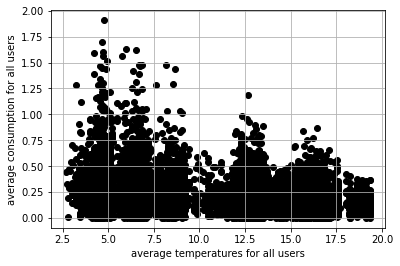

In [9]:
#Plotting the data: 
plt.scatter(nptemps,npEn_con, color = 'black')
plt.xlabel("average temperatures for all users")
plt.ylabel("average consumption for all users")
plt.grid()

### Univariate linear regression

Creating 3 separate univariate linear regression as a function of average temperature, min, max.

In [10]:
# Split the data into training/testing sets
#X_train = nptemps[:-2000] # all elements except last 2000 = 90% training set.
X_train = nptemps[:-6322] #70% trainning set
X_train = X_train.reshape(-1,1)

X_test = nptemps[-6322:] #  last 6322 elements are the test set
X_test = X_test.reshape(-1,1)
                       
X_train_min = nptemps_min[:-6322]
X_train_min = X_train_min.reshape(-1,1)

X_test_min = nptemps_min[-6322:]
X_test_min = X_test_min.reshape(-1,1)

X_train_max = nptemps_max[:-6322]
X_train_max = X_train_max.reshape(-1,1)

X_test_max = nptemps_max[-6322:]
X_test_max = X_test_max.reshape(-1,1)
# Split the targets into training/testing sets
y_train = npEn_con[:-6322]
y_train = npEn_con[:-6322].reshape(-1,1)

y_test = npEn_con[-6322:]
y_test = y_test.reshape(-1,1)

# Create linear regression object
regr = linear_model.LinearRegression()
regr_min= linear_model.LinearRegression()
regr_max= linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)
regr_min.fit(X_train_min, y_train)
regr_max.fit(X_train_max, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)
y_pred_min = regr_min.predict(X_test_min)
y_pred_max = regr_max.predict(X_test_max)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.8f'
      % mean_squared_error(y_test, y_pred))
print('Mean squared error min: %.8f'
      % mean_squared_error(y_test, y_pred_min))
print('Mean squared error max: %.8f'
      % mean_squared_error(y_test, y_pred_max))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

Coefficients: 
 [[-0.00831305]]
Mean squared error: 0.02165862
Mean squared error min: 0.02170810
Mean squared error max: 0.02164935
Coefficient of determination: 0.05


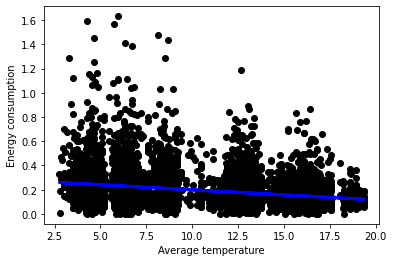

In [11]:
# Plot outputs
plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=3)
plt.xlabel("Average temperature")
plt.ylabel("Energy consumption")


plt.show()

### Combine temps for multi linear model

In [12]:
np_combinedtemps= np.zeros(shape = (len(temps), 3))

for i in range(len(temps)):
    
    np_combinedtemps[i, 0] = temps[i]
    np_combinedtemps[i, 1] = temps_min[i]
    np_combinedtemps[i, 2]  = temps_max[i]

In [13]:
#Training:

# Split the data into training/testing sets
X_train_comb = np_combinedtemps[:-6322]
X_test_comb = np_combinedtemps[-6322:]

# Split the targets into training/testing sets
y_train = npEn_con[:-6322]
y_test = npEn_con[-6322:]


# Create linear regression object
regr_comb = linear_model.LinearRegression()

# Train the model using the training sets
regr_comb.fit(X_train_comb, y_train)


# Make predictions using the testing set
y_pred_comb = regr_comb.predict(X_test_comb)


# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.8f'
      % mean_squared_error(y_test, y_pred_comb))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred_comb))

Coefficients: 
 [[-0.00831305]]
Mean squared error: 0.02164496
Coefficient of determination: 0.05


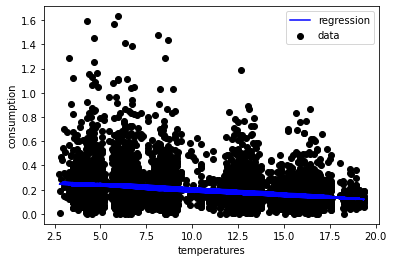

In [14]:
# Plot outputs
plt.scatter(X_test, y_test,  color='black', label ="data")
plt.plot(X_test, y_pred_comb, color='blue',  label = "regression")
plt.legend()
plt.xlabel("temperatures")
plt.ylabel("consumption")
plt.show()

### Including the months in the model's training set:

In [15]:
np_features= np.zeros(shape = (len(temps), 4))

for i in range(len(temps)):
    
    np_features[i, 0] = temps[i]
    np_features[i, 1] = temps_min[i]
    np_features[i, 2]  = temps_max[i]
    np_features[i, 3]  = month_arr[i]


In [16]:
#Training:

# Split the data into training/testing sets
X_train_comb = np_features[:-6322]
X_test_comb = np_features[-6322:]

# Split the targets into training/testing sets
y_train = npEn_con[:-6322]
y_test = npEn_con[-6322:]


# Create linear regression object
regr_comb = linear_model.LinearRegression()

# Train the model using the training sets
regr_comb.fit(X_train_comb, y_train)


# Make predictions using the testing set
y_pred_comb = regr_comb.predict(X_test_comb)


# The coefficients
print('Coefficients: \n', regr_comb.coef_)
# The mean squared error
print('Mean squared error: %.8f'
      % mean_squared_error(y_test, y_pred_comb))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred_comb))

Coefficients: 
 [ 0.03033648 -0.01892898 -0.01855107  0.00239188]
Mean squared error: 0.02185707
Coefficient of determination: 0.04


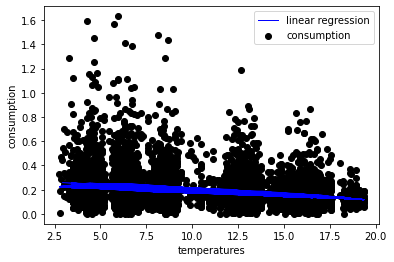

In [17]:
# Plot outputs
plt.scatter(X_test, y_test,  color='black', label = "consumption")
plt.plot(X_test, y_pred_comb, color='blue', linewidth=1, label = "linear regression")
plt.legend()
plt.xlabel("temperatures")
plt.ylabel("consumption")
plt.show()

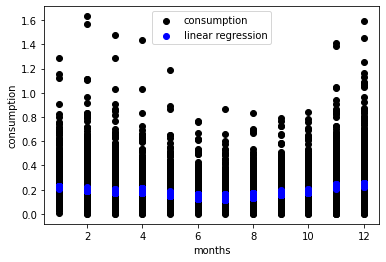

In [19]:
months_test = npmonth_arr[-6322: ]
# Plot outputs
plt.scatter(months_test, y_test,  color='black', label = "consumption")
plt.scatter(months_test, y_pred_comb, color='blue', label = "linear regression")
plt.legend()
plt.xlabel("months")
plt.ylabel("consumption")
plt.show()

### Polynomial Regression:

In [20]:
train_months=npmonth_arr[:-6322]
print(train_months.shape)
train_months=train_months.reshape(-1, 1)
train_months.shape

(14752,)


(14752, 1)

In [21]:
# Split the data into training/testing sets
X_train_comb = np_features[:-6322]
X_test_comb = np_features[-6322:]

# Split the targets into training/testing sets
y_train = npEn_con[:-6322]
y_test = npEn_con[-6322:]


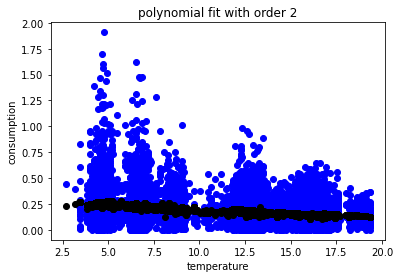

Coefficients: 
 [ 0.00000000e+00  3.31725821e-01 -1.87500184e-01 -1.55793193e-01
 -1.23532130e-02 -1.74015439e-02  4.83795998e-02 -1.85114853e-02
  9.03505755e-04 -2.11992614e-02 -3.94942126e-03  6.73582317e-05
  1.27433111e-02 -7.78005312e-04  1.01614182e-03]
Mean squared error: 0.02180203
Coefficient of determination: 0.04709585


In [22]:
# Fitting Polynomial Regression to the dataset
# source: https://towardsdatascience.com/machine-learning-polynomial-regression-with-python-5328e4e8a386
from sklearn.preprocessing import PolynomialFeatures
# Create polynomial regression object
polynom_degree = 2

poly_reg = PolynomialFeatures(degree = polynom_degree)

X_poly = poly_reg.fit_transform(X_train_comb) # Fit to data, then transform it to 
    #a new feature matrix consisting ofall polynomial combinations of the features

pol_reg = LinearRegression()

# Train the model using the training sets
pol_reg.fit(X_poly, y_train)

# polyfitting the training data:
poly_vals = pol_reg.predict(poly_reg.fit_transform(X_train_comb))

# Make predictions using the testing set
y_pred_poly = pol_reg.predict(poly_reg.fit_transform(X_test_comb))

# Visualizing the Polymonial Regression results
def viz_polymonial():
    plt.scatter(X_train, y_train, color='blue')
    plt.scatter(X_train, poly_vals, color='black')
    plt.xlabel('temperature')
    plt.ylabel('consumption')
    plt.title("polynomial fit with order " +str(polynom_degree))
    plt.show()
    return
viz_polymonial()
# The coefficients
print('Coefficients: \n', pol_reg.coef_)
# The mean squared error
print('Mean squared error: %.8f'
      % mean_squared_error(y_test, y_pred_poly))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.8f'
      % r2_score(y_test, y_pred_poly))

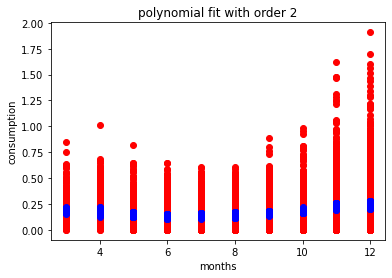

In [23]:
plt.scatter(train_months, y_train, color='red')
plt.scatter(train_months, poly_vals, color='blue')
plt.xlabel('months')
plt.ylabel('consumption')
plt.title("polynomial fit with order " +str(polynom_degree))
plt.show()

In [24]:
brinfo=info_sorted['num_bedrooms']
br_NaNs_number = brinfo.isnull().sum()
print("number of users with+NaN bedroom info = ", brinfo.shape[0])
print("number of users with NaN bedroom info = ", br_NaNs_number)
print("percentage of NaN values in num_bedrooms = ", br_NaNs_number/brinfo.shape[0])
print(np_features.shape)

number of users with+NaN bedroom info =  3248
number of users with NaN bedroom info =  1389
percentage of NaN values in num_bedrooms =  0.42764778325123154
(21074, 4)


In [29]:
#Getting the mean for the training set:

# # Filling the mean value for the NaN values in num_bedrooms column:
# # We should include the mean value of the training data not the whole data.

br_arr_training = br_arr[:-6322]


#convert it to numpy:
npbr_arr_training = np.zeros(len(br_arr_training)) #converting it into numpy array.
for i in range(len(br_arr_training)):
    npbr_arr_training[i] = br_arr[i]
    
#ignore NaN values:
npbr_arr_training_ = npbr_arr_training[np.logical_not(np.isnan(npbr_arr_training))] 
#get the mean of the training data
mean_br_arr_training = npbr_arr_training_.mean()

values = {'num_bedrooms' : mean_br_arr_training}
info_filled_br = info_sorted.fillna(value = values)

info_filled_br

,dwelling_type,num_occupants,num_bedrooms,heating_fuel,hot_water_fuel,boiler_age,loft_insulation,wall_insulation,heating_temperature,efficient_lighting_percentage,...,refrigerator,tumble_dryer,washing_machine,game_console,laptop,pc,router,set_top_box,tablet,tv
meter_id,,,,,,,,,,,,,,,,,,,,,
0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,terraced_house,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0x459c834d1f6cfb5b734b82aa9f5410fa97fb70da,NaN,NaN,3.103012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0x4a1ed36825360a058cec2bdd409fc2459e1ce54f,NaN,NaN,3.103012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0x5b76d3c0e0aefc6e0a8d1d031f96388a23263407,NaN,NaN,3.103012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0x943ebe39ef2be6ef807c42c5a647e27112ca5b0f,NaN,NaN,3.103012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0x7dd7a7b8ee1bec7c44b24f738c752482f6161065,NaN,NaN,3.103012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0xfdaf9f857621ec06f2cf801f42a020a322835090,NaN,NaN,3.103012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0xd28f2f001e0cd4d6c121a3cb2e1427207e170e18,terraced_house,NaN,3.103012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
print(npbr_arr_training.shape)
npEn_con_training = npEn_con[: -6322]
print(npEn_con_training.shape)

(35826,)
(14752,)


In [32]:
npbr_arr = np.zeros(len(br_arr)) #converting it into numpy array.

for i in range(len(br_arr)):
    npbr_arr[i] = br_arr[i]
    
#filling npbr_arr with the mean value of the training data

npbr_arr_filled =np.nan_to_num(npbr_arr, copy=True, nan=mean_br_arr_training, posinf=None, neginf=None)
npbr_arr_filled


array([2.        , 3.10301193, 3.10301193, ..., 3.10301193, 3.10301193,
       3.10301193])

#### Linear and polynomial multivariate regression

In [33]:
combinefeatures=[]
for i in range(len(temps)):
    temp=[]
    temp.append(temps[i])
    temp.append(temps_min[i])
    temp.append(temps_max[i])
    temp.append(month_arr[i])
    temp.append(npbr_arr_filled[i]) #filled with the average of training data.
    combinefeatures.append(temp)
    
npcombinefeatures=np.array(combinefeatures)
npcombinefeatures=npcombinefeatures.reshape(-1,5)

In [34]:
brinfo_sorted_dim = npcombinefeatures[:, 4]
brinfo_sorted_dim[:-6322].mean()

3.110089373849711

In [35]:
#Linear regression: 
# Split the data into training/testing sets
X_train_comb = npcombinefeatures[:-6322]
X_test_comb = npcombinefeatures[-6322:]

# Split the targets into training/testing sets
y_train = npEn_con[:-6322]
y_test = npEn_con[-6322:]


# Create linear regression object
regr_comb = linear_model.LinearRegression()

# Train the model using the training sets
regr_comb.fit(X_train_comb, y_train)


# Make predictions using the testing set
y_pred_comb = regr_comb.predict(X_test_comb)

# The coefficients
print('Coefficients: \n', regr_comb.coef_)
# The mean squared error
print('Mean squared error: %.8f'
      % mean_squared_error(y_test, y_pred_comb))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred_comb))

Coefficients: 
 [ 0.02840793 -0.01707619 -0.01829429  0.00225276  0.04837594]
Mean squared error: 0.02132022
Coefficient of determination: 0.07


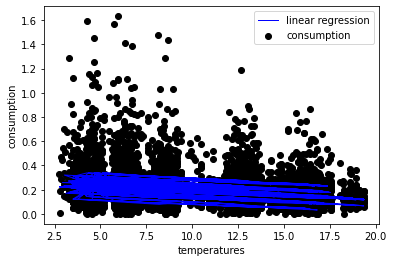

In [36]:
plt.scatter(X_test, y_test,  color='black', label = "consumption")
plt.plot(X_test, y_pred_comb, color='blue', linewidth=1, label = "linear regression")
plt.legend()
plt.xlabel("temperatures")
plt.ylabel("consumption")
plt.show()

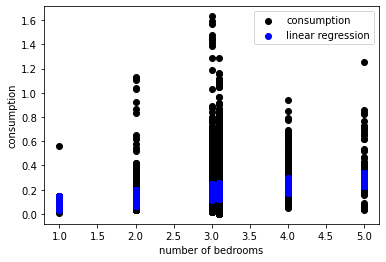

In [37]:
test_br = npcombinefeatures[:, 4][-6322:]
plt.scatter(test_br, y_test,  color='black', label = "consumption")
plt.scatter(test_br, y_pred_comb, color='blue', linewidth=1, label = "linear regression")
plt.legend()
plt.xlabel("number of bedrooms")
plt.ylabel("consumption")
plt.show()

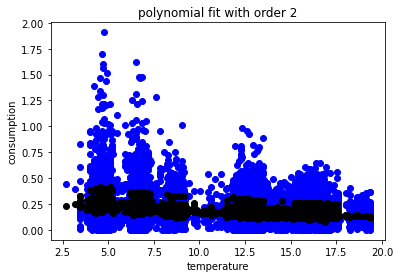

Coefficients: 
 [ 0.00000000e+00  3.08288348e-01 -1.65887655e-01 -1.48024577e-01
 -8.88065408e-03  6.41935985e-03  9.90160359e-03  1.86788209e-02
 -4.39168681e-02 -1.05737375e-03  8.88215593e-03 -1.30772267e-02
  9.74524479e-03  9.22780071e-04 -6.25004011e-03  1.87381674e-02
  3.01023758e-04 -4.53283100e-03  9.49873080e-04 -1.08363292e-03
  1.01405462e-02]
Mean squared error: 0.02123692
Coefficient of determination: 0.07179495


In [38]:
#Polynomial regression:

X_train_comb = npcombinefeatures[:-6322]
X_test_comb = npcombinefeatures[-6322:]

# Split the targets into training/testing sets
y_train = npEn_con[:-6322]
y_test = npEn_con[-6322:]



# Fitting Polynomial Regression to the dataset
# source: https://towardsdatascience.com/machine-learning-polynomial-regression-with-python-5328e4e8a386
from sklearn.preprocessing import PolynomialFeatures
# Create polynomial regression object
polynom_degree = 2

poly_reg = PolynomialFeatures(degree = polynom_degree)

X_poly = poly_reg.fit_transform(X_train_comb) # Fit to data, then transform it to 
    #a new feature matrix consisting ofall polynomial combinations of the features

pol_reg = LinearRegression()

# Train the model using the training sets
pol_reg.fit(X_poly, y_train)

# polyfitting the training data:
poly_vals = pol_reg.predict(poly_reg.fit_transform(X_train_comb))

# Make predictions using the testing set
y_pred_poly = pol_reg.predict(poly_reg.fit_transform(X_test_comb))

# Visualizing the Polymonial Regression results
def viz_polymonial():
    plt.scatter(X_train, y_train, color='blue')
    plt.scatter(X_train, poly_vals, color='black')
    plt.xlabel('temperature')
    plt.ylabel('consumption')
    plt.title("polynomial fit with order " +str(polynom_degree))
    plt.show()
    return
viz_polymonial()
# The coefficients
print('Coefficients: \n', pol_reg.coef_)
# The mean squared error
print('Mean squared error: %.8f'
      % mean_squared_error(y_test, y_pred_poly))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.8f'
      % r2_score(y_test, y_pred_poly))

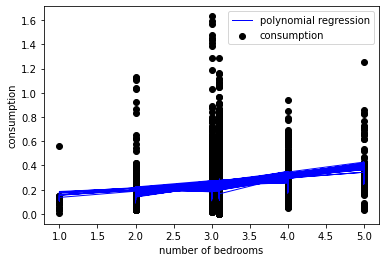

In [39]:
plt.scatter(test_br, y_test,  color='black', label = "consumption")
plt.plot(test_br, y_pred_poly, color='blue', linewidth=1, label = "polynomial regression")
plt.legend()
plt.xlabel("number of bedrooms")
plt.ylabel("consumption")
plt.show()

In [41]:
#Feature Scaling:

from sklearn import preprocessing
X_train_comb = npcombinefeatures[:-6322]
X_test_comb = npcombinefeatures[-6322:]

# Split the targets into training/testing sets
y_train = npEn_con[:-6322]
y_test = npEn_con[-6322:]


X_scaled_train = preprocessing.scale(X_train_comb)
X_scaled_test = preprocessing.scale(X_test_comb)

y_scaled_train = preprocessing.scale(y_train)
y_scaled_test = preprocessing.scale(y_test)

#X_train_comb[i][0]    #= average temperature
X_train_comb[:, 0] # = average temperature.
print("non scaled = ", X_train_comb[0][0])
print("non scaled = ", X_train[0][0])
print("scaled = ", X_scaled_train[0][0])
X_scaled_train[:, 0] # = average temperatures scaled.
avg_temps_scaled = X_scaled_train[:, 0] 

non scaled =  meter_id
0xa62b9f23553ff183f61e2bf943aab3d5983d02d7    4.681048
dtype: float64
non scaled =  4.681048387096775
scaled =  -1.468143153102461


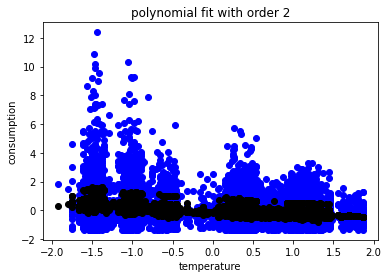

Coefficients: 
 [ 0.          1.67878311 -0.81477857 -1.057434    0.08038899  0.17137966
  1.38302219  2.32887653 -6.9911382  -0.08187927  0.14997426 -1.45541235
  1.38478603  0.06378478 -0.09420079  3.39966837  0.02656679 -0.08722898
  0.04077865 -0.01014384  0.02069829]
Mean squared error: 0.93233182
Coefficient of determination: 0.06766818


In [42]:
#Polynomial regression:

# Fitting Polynomial Regression to the dataset
# source: https://towardsdatascience.com/machine-learning-polynomial-regression-with-python-5328e4e8a386
from sklearn.preprocessing import PolynomialFeatures
# Create polynomial regression object
polynom_degree = 2

poly_reg = PolynomialFeatures(degree = polynom_degree)

X_poly = poly_reg.fit_transform(X_scaled_train) # Fit to data, then transform it to 
    #a new feature matrix consisting ofall polynomial combinations of the features

pol_reg = LinearRegression()

# Train the model using the training sets
pol_reg.fit(X_poly, y_scaled_train)

# polyfitting the training data:
poly_vals = pol_reg.predict(poly_reg.fit_transform(X_scaled_train))

# Make predictions using the testing set
y_pred_poly = pol_reg.predict(poly_reg.fit_transform(X_scaled_test))

# Visualizing the Polymonial Regression results
def viz_polymonial():
    plt.scatter(avg_temps_scaled, y_scaled_train, color='blue')
    plt.scatter(avg_temps_scaled, poly_vals, color='black')
    plt.xlabel('temperature')
    plt.ylabel('consumption')
    plt.title("polynomial fit with order " +str(polynom_degree))
    plt.show()
    return
viz_polymonial()
# The coefficients
print('Coefficients: \n', pol_reg.coef_)
# The mean squared error
print('Mean squared error: %.8f'
      % mean_squared_error(y_scaled_test, y_pred_poly))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.8f'
      % r2_score(y_scaled_test, y_pred_poly))

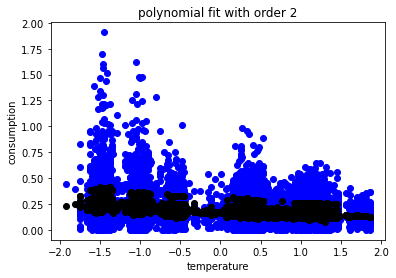

Coefficients: 
 [ 0.          0.23307805 -0.11312182 -0.14681149  0.01116101  0.02379392
  0.19201534  0.3233354  -0.97063216 -0.01136791  0.02082205 -0.20206581
  0.19226023  0.00885572 -0.0130786   0.47200146  0.00368847 -0.01211065
  0.00566161 -0.00140835  0.0028737 ]
Mean squared error: 0.02137801
Coefficient of determination: 0.06562828


In [43]:
#Not scaling consumption:

#Polynomial regression:

# Fitting Polynomial Regression to the dataset
# source: https://towardsdatascience.com/machine-learning-polynomial-regression-with-python-5328e4e8a386
from sklearn.preprocessing import PolynomialFeatures
# Create polynomial regression object
polynom_degree = 2

poly_reg = PolynomialFeatures(degree = polynom_degree)

X_poly = poly_reg.fit_transform(X_scaled_train) # Fit to data, then transform it to 
    #a new feature matrix consisting ofall polynomial combinations of the features

pol_reg = LinearRegression()

# Train the model using the training sets
pol_reg.fit(X_poly, y_train)

# polyfitting the training data:
poly_vals = pol_reg.predict(poly_reg.fit_transform(X_scaled_train))

# Make predictions using the testing set
y_pred_poly = pol_reg.predict(poly_reg.fit_transform(X_scaled_test))

# Visualizing the Polymonial Regression results
def viz_polymonial():
    plt.scatter(avg_temps_scaled, y_train, color='blue')
    plt.scatter(avg_temps_scaled, poly_vals, color='black')
    plt.xlabel('temperature')
    plt.ylabel('consumption')
    plt.title("polynomial fit with order " +str(polynom_degree))
    plt.show()
    return
viz_polymonial()
# The coefficients
print('Coefficients: \n', pol_reg.coef_)
# The mean squared error
print('Mean squared error: %.8f'
      % mean_squared_error(y_test, y_pred_poly))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.8f'
      % r2_score(y_test, y_pred_poly))

In [44]:
#Lin reg. with feature scaling:

# Create linear regression object
regr_comb_sc = linear_model.LinearRegression()

# Train the model using the training sets
regr_comb_sc.fit(X_scaled_train, y_train)


# Make predictions using the testing set
y_pred_comb_sc = regr_comb_sc.predict(X_scaled_test)

# The coefficients
print('Coefficients: \n', regr_comb_sc.coef_)
# The mean squared error
print('Mean squared error: %.8f'
      % mean_squared_error(y_test, y_pred_comb_sc))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred_comb_sc))

Coefficients: 
 [ 0.12509927 -0.06712425 -0.09181711  0.00549986  0.0257525 ]
Mean squared error: 0.02112762
Coefficient of determination: 0.08
